In [1]:
import numpy as np
import pandas as pd
from setuptools.command.rotate import rotate
from six import print_

from pyaw import utils_cal, configs, swarm
import importlib
importlib.reload(utils)
importlib.reload(configs)
importlib.reload(swarm)

<module 'pyaw.swarm' from 'D:\\cleo\\master\\pyaw\\pyaw\\swarm.py'>

In [2]:
fp_e = r"\\Diskstation1\file_three\aw\swarm\A\efi16\sw_efi16A_20160311T000000_20160311T235959_0.pkl"
fp_b = r"\\Diskstation1\file_three\aw\swarm\A\vfm50\sw_vfm50A_20160311T060000_20160311T070000_0.pkl"
start = '20160311T064700'
end = '20160311T064900'

In [3]:
df_e = swarm.pre_e(fp_e,start,end,handle_outliers=True)
df_b = swarm.pre_b(fp_b,start,end,handle_outliers=True)

df['eh_sc1'] set nan:
20
datetime
2016-03-11 06:47:02.381750107    -25.189461
2016-03-11 06:47:02.881750107    -52.246895
2016-03-11 06:47:05.193749905    -77.747688
2016-03-11 06:47:08.381750107     32.064510
2016-03-11 06:47:12.318749905    122.049973
2016-03-11 06:47:13.193749905    -50.420204
2016-03-11 06:47:20.443749905    -52.979156
2016-03-11 06:47:23.318749905    -57.540714
2016-03-11 06:47:25.443749905     90.709106
2016-03-11 06:47:31.818749905     35.128010
2016-03-11 06:47:32.193749905     71.152878
2016-03-11 06:47:32.506750107     56.372738
2016-03-11 06:47:47.443749905     31.657372
2016-03-11 06:47:48.443749905     27.904247
2016-03-11 06:47:48.568749905     58.081692
2016-03-11 06:47:48.631750107   -630.023132
2016-03-11 06:47:48.693749905   -665.179688
2016-03-11 06:47:48.756750107   -455.312073
2016-03-11 06:47:49.568749905    209.649460
2016-03-11 06:47:53.193749905    125.686043
Name: eh_sc1, dtype: float32

df['eh_sc2'] set nan:
21
datetime
2016-03-11 06:47:04.13

In [4]:
df_e['timestamp'] = df_e.index.astype('int64')
df_b['timestamp'] = df_b.index.astype('int64')

In [5]:
from scipy.interpolate import interp1d
interp_func1 = interp1d(df_e['timestamp'], df_e['eh1_enu1'], kind='linear', fill_value="extrapolate")
interp_func2 = interp1d(df_e['timestamp'], df_e['eh1_enu2'], kind='linear', fill_value="extrapolate")
df_b['eh1_enu1_interp'] = interp_func1(df_b['timestamp'])
df_b['eh1_enu2_interp'] = interp_func2(df_b['timestamp'])

In [6]:
e = df_b['eh1_enu2_interp']
b = df_b['b1_enu1']

In [7]:
from scipy.signal import butter, filtfilt


# 1. 设计带通滤波器
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # 计算 Nyquist 频率
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return b, a

# 2. 应用带通滤波器
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 设置滤波参数
lowcut = 0.2  # 带通滤波器下限频率
highcut = 4.0  # 带通滤波器上限频率

In [8]:
fs = 50

In [9]:
e_filter = pd.Series(index=e.index,data=bandpass_filter(e, lowcut, highcut, fs=fs))
b_filter = pd.Series(index=e.index,data=bandpass_filter(b, lowcut, highcut, fs=fs))

(<Axes: xlabel='datetime'>, <Axes: xlabel='datetime'>)

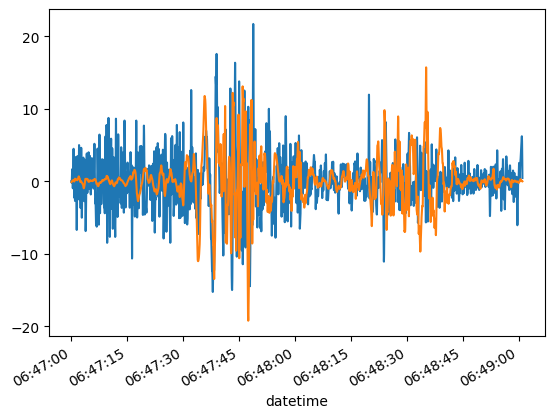

In [10]:
e_filter.plot(),b_filter.plot()

In [29]:
from scipy.signal import spectrogram
nperseg = 2**6

Text(0.5, 1.0, 'e')

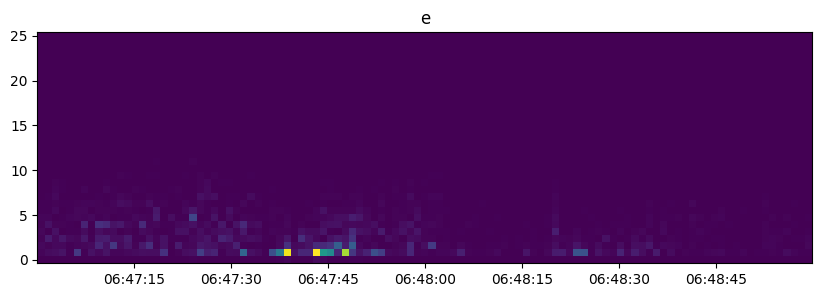

In [30]:
signal = e
frequencies, times, Sxx = spectrogram(signal.values, fs=fs,nperseg=nperseg)
from datetime import timedelta
ts = []
for time in times:
    ts.append(pd.to_datetime(start) + timedelta(seconds=time))
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 3))
plt.pcolormesh(ts,frequencies,Sxx)
# plt.ylim([0,8])
plt.title("e")

Text(0.5, 1.0, 'e_filter')

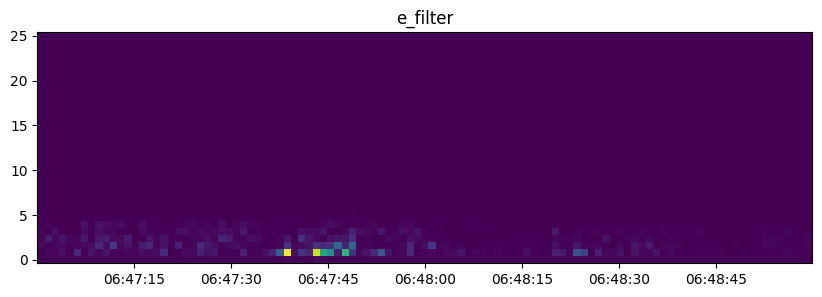

In [31]:
signal = e_filter
frequencies, times, Sxx = spectrogram(signal.values, fs=fs,nperseg=nperseg)
from datetime import timedelta
ts = []
for time in times:
    ts.append(pd.to_datetime(start) + timedelta(seconds=time))
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 3))
plt.pcolormesh(ts,frequencies,Sxx)
plt.title("e_filter")

Text(0.5, 1.0, 'b')

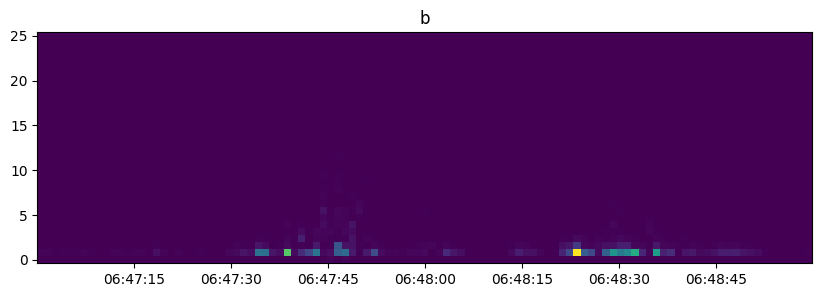

In [32]:
signal = b
frequencies, times, Sxx = spectrogram(signal.values, fs=fs,nperseg=nperseg)
from datetime import timedelta
ts = []
for time in times:
    ts.append(pd.to_datetime(start) + timedelta(seconds=time))
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 3))
plt.pcolormesh(ts,frequencies,Sxx)
plt.title("b")

Text(0.5, 1.0, 'b_filter')

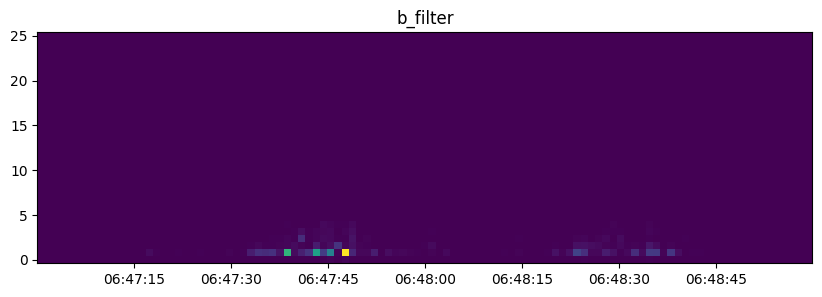

In [33]:
signal = b_filter
frequencies, times, Sxx = spectrogram(signal.values, fs=fs,nperseg=nperseg)
from datetime import timedelta
ts = []
for time in times:
    ts.append(pd.to_datetime(start) + timedelta(seconds=time))
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 3))
plt.pcolormesh(ts,frequencies,Sxx)
plt.title("b_filter")

Text(0.5, 1.0, 'e vs b')

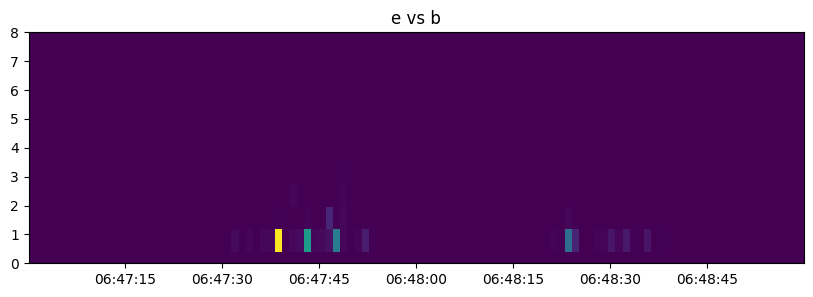

In [35]:
signal1 = e
signal2 = b
frequencies1, times1, Sxx1 = spectrogram(signal1.values, fs=fs,nperseg=nperseg)
frequencies2, times2, Sxx2 = spectrogram(signal2.values, fs=fs,nperseg=nperseg)
cross_spectrogram = Sxx1 * np.conj(Sxx2)
plt.figure(figsize=(10, 3))
plt.pcolormesh(ts,frequencies1,cross_spectrogram)
plt.ylim([0,8])
plt.title("e vs b")